# Author's Classification NLP
Classification of authors by fragments of texts using different NLP techniques.

## Import dependencies

In [2]:
from text_mining_toolkit import txt_mining_tool
from text_mining_toolkit import preprocess_data
from text_mining_classify import classification_battery
import os
import pandas as pd
import string
import numpy as np

In [ ]:
# To check the documentation of the class created by us use the following code:
#print(classification_battery.__doc__)

# 1. DATA CLEANING

During this step we are creating the dataset. The idea is to go through all the files of the train set in the corpora, we remove the headers of each text and after that we created a dataset with chunks of 1000 words for each record.

### Read data and create dataset

In [3]:
def read_data(train_directory):
    df = pd.DataFrame(columns=["TextName", "Author", "Text"])
    for entry in os.listdir(train_directory):
        if os.path.isdir(os.path.join(train_directory, entry)):
            for file in os.listdir(train_directory+'/'+entry):
                with open(train_directory+'/'+entry+'/'+file, 'r', encoding="utf-8") as f:
                    data = f.read()
                    df = df.append({
                        "TextName": file.replace('.txt', '').split(' -', 1)[0],
                        "Author": entry, 
                        "Text":data }, ignore_index=True)
    return df

In [4]:
my_directory='./Corpora/train'
df_all=read_data(my_directory)
df_all.head()

,TextName,Author,Text
0,pg22615,Almada Negreiros,Title: A Scena do Odio\n\nAuthor: José de Alma...
1,pg22730,Almada Negreiros,Title: O Jardim da Pierrette\n\nAuthor: José d...
2,pg22801,Almada Negreiros,\n\nTitle: A Invenção do Dia Claro\n\nAuthor: ...
3,pg22802,Almada Negreiros,\nTitle: Litoral\n A Amadeo de Souza Car...
4,pg22969,Almada Negreiros,\n\n\nEXPOSIÇÃO\n\n+amadeo\nde souza\ncardoso+...


### Remove headers

In [5]:
# Create a copy of the data
df_nohead = df_all.copy()

# Read file of first line
texts_authors=pd.read_csv('TextsAuthors.csv')

# Merge data
df_nohead=pd.merge(df_nohead, texts_authors, how='left', on=['TextName', 'Author'])

# Remove the header  
for index, row in df_nohead.iterrows():
    text_lines = (df_nohead.at[index,"Text"]).split("\n")
    text_new=''
    index_i = df_nohead.at[index, "FirstLine"]-1
    if index_i < 1:
        index_i = 0
    text_new = '\n'.join(text_lines[index_i:]).strip()
    df_nohead.at[index, 'Text']=text_new
df_nohead.head()

,TextName,Author,Text,FirstLine
0,pg22615,Almada Negreiros,A ALVARO DE CAMPOS\n\n_Excerptos de um poema d...,12
1,pg22730,Almada Negreiros,+Argumento do bailado+\n\n\nPierrot n'aquella ...,13
2,pg22801,Almada Negreiros,AO\n\nMEU AMIGO\n\nFERNANDO AMADO\n\n\n\n\n\n+...,56
3,pg22802,Almada Negreiros,espasmos de praiamar transbordam invasão\na ar...,18
4,pg22969,Almada Negreiros,LIGA NAVAL DE LISBOA\n\n\nEm Portugal existe u...,10


In [6]:
df_nohead.groupby(by='Author').count()

,TextName,Text,FirstLine
Author,,,
Almada Negreiros,9,9,9
Camilo Castelo Branco,20,20,20
Eca De Queiros,5,5,5
Jose Rodrigues Santos,8,8,8
Jose Saramago,12,12,12
Luisa Marques Silva,9,9,9


### Create chunks of 1,000 words

In [7]:
df_parag = df_nohead.copy()
df_parag=df_parag[['TextName', 'Author', 'Text']]
df_parag['NLinesOrig']=df_parag['Text'].str.count('\n')
df_parag['NWordsOrig']=df_parag['Text'].str.split().str.len()

# Number of words by chunks
n=500

for index, row in df_parag.iterrows():
    line=df_parag.at[index, 'Text'].split()
    lista=[' '.join(line[i:i+n]) for i in range(0, len(line), n)]
    df_parag.at[index, 'Text']=lista

df_parag = df_parag.set_index(['TextName', 'Author', 'NLinesOrig', 'NWordsOrig'])['Text'].apply(pd.Series).stack()
df_parag = df_parag.reset_index()
df_parag.columns = ['TextName', 'Author', 'NLinesOrig','NWordsOrig', 'ChunkNum', 'ChunkText']

df_parag['NWordsChunk']=df_parag['ChunkText'].str.split().str.len()

# UNDERSAMPLING 
min_number_samples = df_parag[df_parag['NWordsChunk']==n].groupby(by='Author').count()['TextName'].min()
print(f"Min number of samples with {n} words is {min_number_samples}")
df_parag=df_parag[df_parag['NWordsChunk']==n].groupby('Author').apply(lambda x: x.sample(min_number_samples, random_state = 1)).reset_index(drop=True)

print(df_parag.shape)
df_parag.head()

Min number of samples with 500 words is 81
(486, 7)


,TextName,Author,NLinesOrig,NWordsOrig,ChunkNum,ChunkText,NWordsChunk
0,pg23620,Almada Negreiros,2788,15295,10,"d'ella soffria, poz-se a sonhar uma patria que...",500
1,pg23620,Almada Negreiros,2788,15295,16,"o ter-te visto morta, o mêdo de perder-me. Pro...",500
2,pg23133,Almada Negreiros,608,6317,11,exprime! O que é o escandalo senão o Homem? es...,500
3,pg23620,Almada Negreiros,2788,15295,12,"e passou por essa ilha, e não estava lá o mari...",500
4,pg23620,Almada Negreiros,2788,15295,8,as suas sombras... Foi decerto assim que alli ...,500


In [8]:
pd.DataFrame(df_parag.groupby(by='Author').count().sort_values('TextName', ascending=False)['TextName'])

,TextName
Author,
Almada Negreiros,81
Camilo Castelo Branco,81
Eca De Queiros,81
Jose Rodrigues Santos,81
Jose Saramago,81
Luisa Marques Silva,81


# 2. DATA PREPROCESSING

We are calling the user defined class `preprocess_data` inside the library `text_mining_toolkit` in order to preprocess the dataset. During this step we:

* Made the text lowercase
* Removed stopwords in portuguese
* Removed puntuations according to the portuguese language

Please refer to the documentation of the preprocess_text method for more detail. `preprocess_data.__doc__`

In [ ]:
#print(preprocess_data.__doc__)

In [9]:
# Initialize preprocess_data class
ppd = preprocess_data(lang = 'portuguese')

def cleanText(text):
    clean_txt = ppd.preprocess_text(text
        , lowercase= True
        , rem_stopwords= True
        , lemmatize= False
        , remove_html = False
        , remove_punctuation = True
        , domain_sp_stopwrd=[]
        , regex_sub=[]) #"-{2,5}","\s-\s","-(\s|,|.)"
    return clean_txt

# Create a sample if neccessary (For testing only)
df_parag_sample = df_parag.sample(frac = 1, random_state = 1).reset_index(drop = True)

# Apply preprocess method
df_parag_sample['clean_text'] = df_parag_sample['ChunkText'].apply(cleanText)

# Count number of words
df_parag_sample['NWordsChunk'] = df_parag_sample['ChunkText'].apply(lambda x: len(x.split(" ")))
df_parag_sample['NWordsChunk_clean'] = df_parag_sample['clean_text'].apply(lambda x: len(x.split(" ")))

# Create clean dataset
df_clean = df_parag_sample[['Author', 'ChunkText','NWordsChunk', 'clean_text', 'NWordsChunk_clean']]
print(df_clean.shape)
df_clean.head(10)

(486, 5)


,Author,ChunkText,NWordsChunk,clean_text,NWordsChunk_clean
0,Camilo Castelo Branco,"meus d'aqui em diante, tapavam olhos e ouvidos...",500,daqui diante tapavam olhos ouvidos necessario ...,291
1,Camilo Castelo Branco,"algum sentimento estranho de affecto, podia ta...",500,algum sentimento estranho affecto podia tanto ...,292
2,Eca De Queiros,nenhum. Assim com as minhas occupações: tanto ...,500,nenhum assim occupações tanto sobrecarregavam ...,273
3,Luisa Marques Silva,que eu nunca vira. Nem parecia moldável. Chame...,500,nunca vira parecia moldável chamei homem futur...,243
4,Eca De Queiros,"amarellada, d'uma seda grossa, que ao menor mo...",500,amarellada duma seda grossa menor movimento fa...,302
5,Eca De Queiros,embrulho de papel pardo... Mas ao vêr Carlos a...,500,embrulho papel pardo vêr carlos alli intimamen...,317
6,Eca De Queiros,"de Londres, Semanarios, Magazines, Revistas, I...",500,londres semanarios magazines revistas illustra...,293
7,Eca De Queiros,"besuntado de litteratura, e inclinado a vêr po...",500,besuntado litteratura inclinado vêr toda parte...,308
8,Almada Negreiros,a curiosidade pra lhe ir espreitar as _toillet...,500,curiosidade pra ir espreitar toilletes guarda­...,279
9,Jose Rodrigues Santos,"da guerra, foi ela quem preparou tudo para via...",500,guerra preparou tudo viabilizar casamento filh...,260


# 3. MACHINE LEARNING

During this method we developed the ML classification model in order to classify the chunks of texts in their correspondent author. For so, we first created a `baseline model` using the `K-Nearest Neighbor (KNN)` classification approach. Then, we performed the `model selection` comparing different classification techniques with different parameters. 

The classification models used are:

* «NB»           - Navie Bayes
* «logit»        - Logistic Regression
* «randomForest» - Random Forest
* «SGDC»         - Stochastic Gradient Descent initialization for Linear Models

For this step we are using the user-defined class called `classification_battery` inside the `text_mining_classify` library. Please refere to the documentation for further detail. classification_battery.__doc__

In [ ]:
#print(classification_battery.__doc__)

## Feature Engineering

In [10]:
config = {
        "print"          : True,
        "lang"           : "portuguese",
        "test_size"      : 0.2,
        "classifiers"    : ["NB", "logit", "randomForest", "DecTree", "SGDC"],
        "cross_validate" : True,
        'metric_avg'     : 'weighted'
    }

ylabels   = df_clean["Author"]
Xfeatures = df_clean["clean_text"]

## BASELINE

Inside the dependency, there is a method called `baseline` which performes the KNN algorithm for a range of `k` values. After that, the method returns the metrics of performance out-of-sample (Accuracy, F1-Score, Precision and Recall) and also the mean error for each `k`.  

It's worth to mention that for this baseline model and for the rest of ML approaches we used a validation sample of 20%.

In [11]:
# Initialize the classification class
cls_bat = classification_battery(Xfeatures, ylabels, config)


Baseline - KNN(1)
Accuracy: 0.898 | F1: 0.897 | Recall: 0.898 | Precision: 0.912

Baseline - KNN(2)
Accuracy: 0.888 | F1: 0.883 | Recall: 0.888 | Precision: 0.904

Baseline - KNN(3)
Accuracy: 0.898 | F1: 0.897 | Recall: 0.898 | Precision: 0.901

Baseline - KNN(4)
Accuracy: 0.908 | F1: 0.91 | Recall: 0.908 | Precision: 0.923

Baseline - KNN(5)
Accuracy: 0.949 | F1: 0.949 | Recall: 0.949 | Precision: 0.951

Baseline - KNN(6)
Accuracy: 0.939 | F1: 0.938 | Recall: 0.939 | Precision: 0.94

Baseline - KNN(7)
Accuracy: 0.959 | F1: 0.959 | Recall: 0.959 | Precision: 0.961

Baseline - KNN(8)
Accuracy: 0.939 | F1: 0.938 | Recall: 0.939 | Precision: 0.941

Baseline - KNN(9)
Accuracy: 0.939 | F1: 0.938 | Recall: 0.939 | Precision: 0.941

Baseline - KNN(10)
Accuracy: 0.939 | F1: 0.938 | Recall: 0.939 | Precision: 0.94

Baseline - KNN(11)
Accuracy: 0.949 | F1: 0.948 | Recall: 0.949 | Precision: 0.951

Baseline - KNN(12)
Accuracy: 0.949 | F1: 0.949 | Recall: 0.949 | Precision: 0.951

Baseline - KNN(

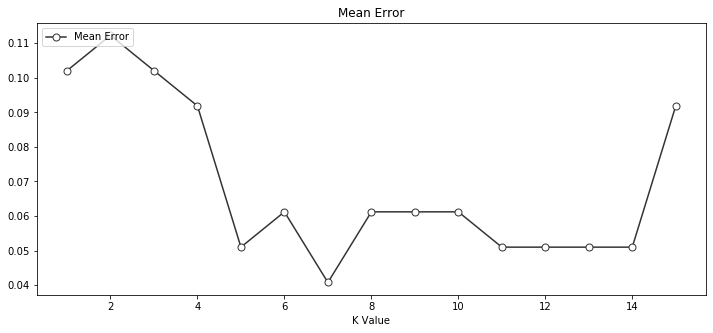

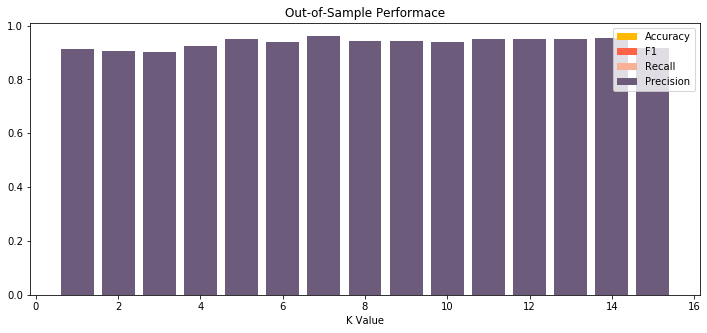

In [12]:
knn_mean_error, metrics_perf = cls_bat.baseline(k_rng=15)

In [15]:
# Summary of metrics performance in baseline
knn_mean_error

[0.10204081632653061,
 0.11224489795918367,
 0.10204081632653061,
 0.09183673469387756,
 0.05102040816326531,
 0.061224489795918366,
 0.04081632653061224,
 0.061224489795918366,
 0.061224489795918366,
 0.061224489795918366,
 0.05102040816326531,
 0.05102040816326531,
 0.05102040816326531,
 0.05102040816326531,
 0.09183673469387756]

## MODEL SELECTION

### Search the best model

During this step the idea is to seach the combination of vectorizers, analizers and ranges of grams that returns the best performance in terms of the metrics (Accuracy, F1, Recall and Precision). 

<b>`Note:`</b> It could take a long time to perform all the combinations and even more if we use cross-validation.

In [16]:
out_perf_AC, out_perf_F1 = cls_bat.search_models(vect_list  = ['tf-idf'],  # 'bag-of-words'
                                analizers  = ['word', 'char', 'char_wb'], 
                                n_rang_lst = [(1,1), (1,2), (1,3), (1,4), (1,5), (2,3)],
                                round_dig = 5)


=================== 1 of 18 ======================
Vectorizer: tf-idf | Analizer: word | n_range: (1, 1) | Using Cross-validation

ACCURACY ====> NB:0.9815 | logit:0.98346 | randomForest:0.64988 | DecTree:0.48775 | SGDC:0.98762 | 
F1       ====> NB:0.98147 | logit:0.98343 | randomForest:0.60137 | DecTree:0.45922 | SGDC:0.9876 | 

=================== 2 of 18 ======================
Vectorizer: tf-idf | Analizer: word | n_range: (1, 2) | Using Cross-validation

ACCURACY ====> NB:0.9815 | logit:0.98554 | randomForest:0.61985 | DecTree:0.48775 | SGDC:0.98762 | 
F1       ====> NB:0.98158 | logit:0.98551 | randomForest:0.60726 | DecTree:0.46173 | SGDC:0.98761 | 

=================== 3 of 18 ======================
Vectorizer: tf-idf | Analizer: word | n_range: (1, 3) | Using Cross-validation

ACCURACY ====> NB:0.97941 | logit:0.98346 | randomForest:0.63174 | DecTree:0.48566 | SGDC:0.98971 | 
F1       ====> NB:0.97949 | logit:0.98328 | randomForest:0.59383 | DecTree:0.45416 | SGDC:0.9897 | 

=

In [18]:
# Sort parametrizations by performance
out_perf_F1

,NB,logit,randomForest,DecTree,SGDC,Vectorizer,Analizer,n_range
0,0.98147,0.98343,0.60137,0.45922,0.98760,tf-idf,word,"(1, 1)"
1,0.98158,0.98551,0.60726,0.46173,0.98761,tf-idf,word,"(1, 2)"
2,0.97949,0.98328,0.59383,0.45416,0.98970,tf-idf,word,"(1, 3)"
3,0.97949,0.97893,0.63308,0.45596,0.98962,tf-idf,word,"(1, 4)"
4,0.97949,0.97893,0.57098,0.45596,0.98582,tf-idf,word,"(1, 5)"
5,0.86459,0.78137,0.39265,0.16964,0.60539,tf-idf,word,"(2, 3)"
6,0.33345,0.51539,0.57226,0.40349,0.54032,tf-idf,char,"(1, 1)"
7,0.45631,0.66075,0.60545,0.53038,0.71387,tf-idf,char,"(1, 2)"
8,0.64143,0.81583,0.60349,0.54047,0.92760,tf-idf,char,"(1, 3)"
9,0.76691,0.90328,0.59034,0.58804,0.93758,tf-idf,char,"(1, 4)"


### Run the best specification

In [19]:
config = {
        "print"          : True,
        "lang"           : "portuguese",
        "test_size"      : 0.2,
        "vectorization"  : "tf-idf",   # "tf-idf" "bag-of-words" "hashing"
        "n_gram"         : "word",     # 'word', 'char', 'char_wb'
        "n_range"        : (1,2),      # (1,1), (1,2), (1,3), (1,4), (1,5), (2,3)
        "metric_avg"     : "weighted",     # None, binary (default), micro, macro, samples, weighted
        "classifiers"    : ["NB", "logit", "randomForest", "DecTree", "SGDC"],
        "cross_validate" : True
    }

best_model = classification_battery(Xfeatures, ylabels, config)

In [21]:
# Run best baseline model
knn_mean_error, metrics_perf, model_spec = best_model.baseline(specific=7)

# Run best model
df_performance = best_model.run_models()

Specific value 7 has been selected.

Baseline - KNN(7)
Accuracy: 0.959 | F1: 0.959 | Recall: 0.959 | Precision: 0.961

Naive Bayes <cross-validation>
Accuracy: 0.9815 | F1: 0.98158 | Recall: 0.9815 | Precision: 0.98319

Logistic <cross-validation>
Accuracy: 0.98554 | F1: 0.98551 | Recall: 0.98554 | Precision: 0.9866

Random Forest <cross-validation>
Accuracy: 0.61924 | F1: 0.60289 | Recall: 0.62316 | Precision: 0.62866

Decision Tree <cross-validation>
Accuracy: 0.48775 | F1: 0.46173 | Recall: 0.48775 | Precision: 0.61762

Stochastic Gradient Descent (SGD) <cross-validation>
Accuracy: 0.98762 | F1: 0.98761 | Recall: 0.98762 | Precision: 0.98834


In [22]:
df_results = pd.DataFrame(columns=['Model','Accuracy', 'F1', 'Recall', 'Precision'])
for i in best_model.config['classifiers']:
    df_results = df_results.append({
        'Model'     : i,
        'Accuracy'  : df_performance[i]['accuracy'],
        'F1'        : df_performance[i]['f1'],
        'Recall'    : df_performance[i]['recall'], 
        'Precision' : df_performance[i]['precision']
    }, ignore_index = True)

# Include Baseline
df_results = df_results.append({
    'Model'     : 'Baseline (KNN)',
    'Accuracy'  : metrics_perf['accuracy'][0],
    'F1'        : metrics_perf['f1'][0],
    'Recall'    : metrics_perf['recall'][0], 
    'Precision' : metrics_perf['precision'][0]
}, ignore_index = True)

df_results.set_index('Model', inplace = True)
df_results

,Accuracy,F1,Recall,Precision
Model,,,,
NB,0.981495,0.981579,0.981495,0.983190
logit,0.985539,0.985513,0.985539,0.986601
randomForest,0.619240,0.602891,0.623162,0.628660
DecTree,0.487745,0.461725,0.487745,0.617616
SGDC,0.987623,0.987611,0.987623,0.988344
Baseline (KNN),0.959184,0.959122,0.959184,0.961383


In [ ]:
import eli5
model_id = 'logit'
features_w_logit = eli5.show_weights(df_performance[model_id]['model'], vec = df_performance[model_id]['cv'], top = 15)
features_w_logit

# Predict Test

In [23]:
def testing_data(directoryPath, model, clean_text = True):
    d = dict()
    df_results = pd.DataFrame()
    if os.path.isdir(directoryPath):
        print(f"Directory: {directoryPath}")
        for file in os.listdir(directoryPath):
            test_sample = open(f"{directoryPath}/{file}", 'r', encoding="utf-8")
            sample = [test_sample.read()]
            if clean_text:
                ts = model.predict_sample([cleanText(sample[0])], printIt = False)
            else:
                ts = model.predict_sample(sample, printIt = False)
            d = {i[0]:i[1] for i in ts}
            d['File_Name'] = file
            df_results = df_results.append(d, ignore_index = True)
    df_results.set_index('File_Name', inplace = True)
    return df_results

### TEST FOR 500 WORDS

In [24]:
testing_data('./Corpora/test/500Palavras', model = best_model, clean_text = True)

Directory: ./Corpora/test/500Palavras


,DecTree,KNN (BASELINE),NB,SGDC,logit,randomForest
File_Name,,,,,,
text1.txt,Luisa Marques Silva,Jose Saramago,Jose Saramago,Jose Saramago,Jose Saramago,Jose Saramago
text2.txt,Almada Negreiros,Almada Negreiros,Almada Negreiros,Almada Negreiros,Almada Negreiros,Almada Negreiros
text3.txt,Luisa Marques Silva,Jose Rodrigues Santos,Luisa Marques Silva,Luisa Marques Silva,Luisa Marques Silva,Jose Saramago
text4.txt,Camilo Castelo Branco,Eca De Queiros,Eca De Queiros,Eca De Queiros,Eca De Queiros,Camilo Castelo Branco
text5.txt,Camilo Castelo Branco,Camilo Castelo Branco,Camilo Castelo Branco,Camilo Castelo Branco,Camilo Castelo Branco,Eca De Queiros
text6.txt,Luisa Marques Silva,Jose Rodrigues Santos,Jose Rodrigues Santos,Jose Rodrigues Santos,Jose Rodrigues Santos,Jose Rodrigues Santos


* text1 (OK) - José Saramago (O ano da morte de Ricardo Reis)
* text2 (OK) - Almada Negreiros (A Engomadeira)
* text3 (OK) - Luísa Marques Silva (Mistério@Tagus)
* text4 (OK) - Eça de Queiroz (A cidade e as serras)
* text5 (OK) - Camilo Castelo Branco (O vinho do Porto: processo de uma bestialidade ingleza)
* text6 (OK) - José Rodrigues dos Santos (Fúria Divina)

### TEST FOR 1,000 WORDS

In [25]:
testing_data('./Corpora/test/1000Palavras', model = best_model, clean_text = True)

Directory: ./Corpora/test/1000Palavras


,DecTree,KNN (BASELINE),NB,SGDC,logit,randomForest
File_Name,,,,,,
text1.txt,Luisa Marques Silva,Jose Saramago,Jose Saramago,Jose Saramago,Jose Saramago,Camilo Castelo Branco
text2.txt,Almada Negreiros,Almada Negreiros,Almada Negreiros,Almada Negreiros,Almada Negreiros,Almada Negreiros
text3.txt,Luisa Marques Silva,Jose Rodrigues Santos,Luisa Marques Silva,Luisa Marques Silva,Luisa Marques Silva,Jose Saramago
text4.txt,Camilo Castelo Branco,Eca De Queiros,Eca De Queiros,Eca De Queiros,Eca De Queiros,Jose Saramago
text5.txt,Camilo Castelo Branco,Camilo Castelo Branco,Camilo Castelo Branco,Camilo Castelo Branco,Camilo Castelo Branco,Camilo Castelo Branco
text6.txt,Jose Rodrigues Santos,Jose Rodrigues Santos,Jose Rodrigues Santos,Jose Rodrigues Santos,Jose Rodrigues Santos,Luisa Marques Silva
